In [1]:
"""
Generative adversarial network (GAN) for a 1D normal distribution, based on
    http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html
    http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
Original paper:
    Generative adversarial networks.
    https://arxiv.org/abs/1406.2661
"""
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

seed=0

In [2]:
# Data
class DataDistribution2d(object):
    def __init__(self, mu=([2,6]), sigma=([[.25, 1], [.5,.25]])):
        self.mu    = np.array(mu)
        self.sigma = np.array(sigma)

    def change(self, **kwargs):
      self.mu=np.array(kwargs.get('mu'))
      self.sigma=np.array(kwargs.get('sigma'))

    def sample(self, size): #bu dağılımdan 'size' tane örnek üret
        x = np.random.multivariate_normal(self.mu, self.sigma, size)
        return x

In [3]:
# Model - Fake data dist.
class NoiseDistribution(object):
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma

    def sample(self, size, sort=False): #noise dağılımımız (-bound, +bound) aralığında uniform gaussian hale getirebiliriz.
        x = np.random.normal(self.mu, self.sigma, size) #+ np.random.random(size) * 0.01 #gaussian noise
        if sort:
            x = np.sort(x)

        return x

In [4]:
# Model - Fake data dist.
class NoiseDistribution2d(object):
    def __init__(self, mu=([1,2]), sigma=([[.25, 1], [.5,.25]])):
        self.mu    = np.array(mu)
        self.sigma = np.array(sigma)

    def change(self, **kwargs):
      self.mu=np.array(kwargs.get('mu'))
      self.sigma=np.array(kwargs.get('sigma'))

    def sample(self, size):
        x = np.random.multivariate_normal(mean=self.mu, cov=self.sigma, size=size)
        return x

In [5]:
def weight(shape): #shape=nöron sayısı
    bound = np.sqrt(6.0 / np.sum(shape))
    init  = tf.random_uniform_initializer(-bound, bound) #ağırlıkların başlangıç değerleri rastgele uniform dağılımdan, init=tf.random_normal_initializer(stddev=1.0) for gaussian
    return tf.get_variable('W', shape, initializer=init)

def bias(shape):
    init = tf.constant_initializer(0.0) #biasın başlangıç değeri 0
    return tf.get_variable('b', shape, initializer=init)

def linear(name, x, dim): #dim=shape
    with tf.variable_scope(name):
        W = weight([x.get_shape()[-1].value, dim])
        b = bias([dim])
    return tf.matmul(x, W) + b

In [6]:
def generator2d(x, hidden_dim=4):
    x = linear('hidden_1', x, hidden_dim)
    x = tf.nn.softplus(x) # softplus = ln(1+e^x) şeklinde aktivasyon fonksiyonu 
    x = linear('hidden_2', x, hidden_dim) #2. layer'ı ekleyince kaymaya başlıyor(atlama yapıyor)
    x = tf.nn.softplus(x)
    x = linear('output', x, 2)

    return x

In [7]:
def discriminator2d(x, hidden_dim=8):
    x = linear('hidden_1', x, hidden_dim)
    x = tf.nn.relu(x) # tanh(x) olabilir
    x = linear('hidden_2', x, hidden_dim)
    x = tf.nn.relu(x)
    # 3. hidden layer eklenebilir 
    x = linear('logits', x, 1)
    x = tf.sigmoid(x)

    return x

In [8]:
# Gradient descent
def get_train_op(loss, variables, initial_learning_rate,
                 decay=0.96, decay_steps=200):
    # Implement exponential decay of learning rate
    global_step   = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        global_step,
        decay_steps, #200 epochda bir adım miktarını küçült
        decay,
        staircase=True
        )

    # Note that we restrict to subset of variables
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) #optimizasyon adam olabilir, subset değil de tüm variablelarla
    train_op  = optimizer.minimize(loss, global_step, variables)

    return train_op

In [9]:
# Adam
def optimizer(loss, var_list, initial_learning_rate, decay=0.96, decay_steps=500): #decay_steps=500
    step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        step,
        decay_steps, #200 epochda bir adım miktarını küçült
        decay,
        staircase=True
        )
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
        loss,
        global_step=step,
        var_list=var_list
    )
    return optimizer

In [10]:
def get_variables(scope):
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope.name)

In [11]:
def sample(size):
    sample_z  = noise.sample(size)
    feed_dict = {z: sample_z.reshape((-1, 1))}
    return sess.run(G, feed_dict)

In [12]:
# Compare data and GAN distributions
def plot_distributions_2d(data, noise, step, title, data2=None, data3=None, data4=None):
    # Number of samples
    num_samples = 5000

    # Data
    x_data = data.sample(num_samples)

    if(data2):
      x_data2 = data2.sample(num_samples)
    if(data3):
      x_data3 = data3.sample(num_samples) 
    if(data4):
      x_data4 = data4.sample(num_samples) 

    # Generated samples
    x_gan = sample(num_samples)

    # Plot distributions
    plt.scatter(x_data[:,0], x_data[:,1], c='blue', alpha=0.3, label='Data distribution')

    if(data2):
      plt.scatter(x_data2[:,0], x_data2[:,1], c='blue', alpha=0.3)
    if(data3):
      plt.scatter(x_data3[:,0], x_data3[:,1], c='blue', alpha=0.3)    
    if(data4):
      plt.scatter(x_data4[:,0], x_data4[:,1], c='blue', alpha=0.3)
    
    plt.scatter(x_gan[:,0], x_gan[:,1],  c='red', alpha=0.3, label='GAN distribution')
      
    # Plot decision boundary
    #y = decision_boundary(bin_centers)
    #plt.plot(bin_centers, y, color='orange', label='Decision boundary')

    # Set limits
    plt.xlim(-2, 10)
    plt.ylim(-2, 10)

    # Legend
    plt.legend(loc='upper right')

    # Axis labels
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)

    # Save figure
    plt.savefig('bivariate_normal_gan_'+str(step)+'.png')
    plt.close()

In [13]:
# Seed the TF random number generator for reproducible initialization
tf.set_random_seed(seed)
# Seed random number generator
np.random.seed(seed)

# Hyperparameters
learning_rate = 0.001 #0.0001 for 1-d
num_steps     = 10000
batch_size    = 20
check_every   = 1000
noise_bound   = 16.0

In [14]:
# Train 2D DATA
# Define GAN

# Generator
with tf.variable_scope('G') as scope:
    z = tf.placeholder(tf.float32, [None, 1])
    G = generator2d(z)
    G_variables = get_variables(scope)

# Discriminator
with tf.variable_scope('D') as scope:
    x  = tf.placeholder(tf.float32, [None, 2])
    D1 = discriminator2d(x)
    D_variables = get_variables(scope)

    # Copy of the discriminator that receives generator samples
    scope.reuse_variables()
    D2 = discriminator2d(G) #G.shape=2 D1.shape=1

# Losses
D_loss = -tf.reduce_mean(tf.log(D1) + tf.log(1 - D2))
G_loss = -tf.reduce_mean(tf.log(D2))

# Train ops
D_train_op = optimizer(D_loss, D_variables, learning_rate)
G_train_op = optimizer(G_loss, G_variables, learning_rate)


# Print list of variables
print("Variables")
print("---------")
variables  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
num_params = 0
for v in variables:
    num_params += np.prod(v.get_shape().as_list())
    print(v.name, v.get_shape())
print("=> Total number of parameters =", num_params)

# TF session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Data distribution
data = DataDistribution2d()
data2 = DataDistribution2d()
data2.change(mu=([6, 2]), sigma =([[.25, 1], [.5,.25]]))
data3 = DataDistribution2d()
data3.change(mu=([7, 7]), sigma =([[.1, .001], [.001, .01]]))
data4 = DataDistribution2d()
data4.change(mu=([1, 1]), sigma =([[1, -1], [1, -1]])) # mu=([6,2])
#data2=None
#data3=None
#data4=None

# Noise distribution
noise = NoiseDistribution()
#noise.change(mu=([8, 8]), sigma =([[.25, 1], [.5,.25]]))

# Train
for step in range(num_steps):
    # Update discriminator
    batch_x   = data.sample(batch_size) #her epochda dağılımdan batch_size tane örnek üretiyor, belli bir örnek kümesinden örnek seçmiyor!
    if(data2):
      batch_x2   = data2.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x2), axis=0)
    if(data3):
      batch_x3   = data3.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x3), axis=0)    
    if(data4):
      batch_x4   = data4.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x4), axis=0)

    batch_z   = noise.sample(4*batch_size, sort=True) #2 dist ise 2*batch_size

    feed_dict = {x: batch_x, z: batch_z.reshape((-1, 1))} # dağılımlardan bu adımda ürettiğimiz örnekleri daha önceden tanımladığımız placeholderlara atıyoruz
    _, current_D_loss = sess.run([D_train_op, D_loss], feed_dict) 

    # Update generator
    batch_z   = noise.sample(4*batch_size) #başka bir fake data batchi ile generator lossu hesaplanıyor
    feed_dict = {z: batch_z.reshape((-1, 1))} #bu batchi dict şeklinde tutuyoruz
    _, current_G_loss = sess.run([G_train_op, G_loss], feed_dict)

    
    # Progress report
    if (step+1) % check_every == 0:
        title=str("After " + str(step+1) + " steps: \n Discriminator loss=" + str(round(current_D_loss, 4)) + "  Generator loss=" + str(round(current_G_loss, 4)))
        plot_distributions_2d(data, noise, int((step+1)/check_every), title,  data2, data3, data4)

Variables
---------
G/hidden_1/W:0 (1, 4)
G/hidden_1/b:0 (4,)
G/hidden_2/W:0 (4, 4)
G/hidden_2/b:0 (4,)
G/output/W:0 (4, 2)
G/output/b:0 (2,)
D/hidden_1/W:0 (2, 8)
D/hidden_1/b:0 (8,)
D/hidden_2/W:0 (8, 8)
D/hidden_2/b:0 (8,)
D/logits/W:0 (8, 1)
D/logits/b:0 (1,)
=> Total number of parameters = 143


C:\Users\Melike Nur Mermer\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':


In [15]:
noise=NoiseDistribution(16)
x_gan=noise.sample(500, sort=True)

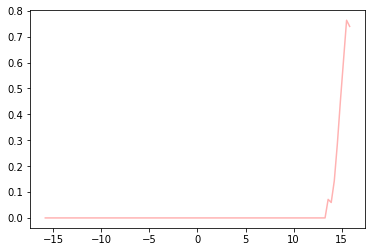

In [16]:
bins = np.linspace(-16, 16, 101) # (-bound, +bound) aralığını 101 parçaya bölüyor
bin_centers = (bins[:-1] + bins[1:])/2
p_gan, _ = np.histogram(x_gan, bins=bins, density=True)
plt.plot(bin_centers, p_gan,  c='red', alpha=0.3, label='GAN distribution')